# Forecasting Covid-19 Cases with LSTM

In [331]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load data

In [332]:
train_df=pd.read_csv("/kaggle/input/covid19-global-forecasting-week-4/train.csv")
test_df=pd.read_csv("/kaggle/input/covid19-global-forecasting-week-4/test.csv")
sub_df=pd.read_csv("/kaggle/input/covid19-global-forecasting-week-4/submission.csv")


In [333]:
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [334]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25666 entries, 0 to 25665
Data columns (total 6 columns):
Id                25666 non-null int64
Province_State    10906 non-null object
Country_Region    25666 non-null object
Date              25666 non-null object
ConfirmedCases    25666 non-null float64
Fatalities        25666 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ MB


In [335]:
# pull out state of North Carolina 
train_df=train_df[train_df["Province_State"]=="North Carolina"]
test_df=test_df[test_df["Province_State"]=="North Carolina"]


In [336]:
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
22222,30895,North Carolina,US,2020-01-22,0.0,0.0
22223,30896,North Carolina,US,2020-01-23,0.0,0.0
22224,30897,North Carolina,US,2020-01-24,0.0,0.0
22225,30898,North Carolina,US,2020-01-25,0.0,0.0
22226,30899,North Carolina,US,2020-01-26,0.0,0.0


In [337]:
train_df.shape,test_df.shape

((82, 6), (43, 4))

In [338]:
# add a data column for days
train_df["days"]=[x for x in range(1,83)]
test_df["days"]=[x for x in range(1,44)]


In [339]:
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,days
22222,30895,North Carolina,US,2020-01-22,0.0,0.0,1
22223,30896,North Carolina,US,2020-01-23,0.0,0.0,2
22224,30897,North Carolina,US,2020-01-24,0.0,0.0,3
22225,30898,North Carolina,US,2020-01-25,0.0,0.0,4
22226,30899,North Carolina,US,2020-01-26,0.0,0.0,5


In [340]:
test_df.head()

,ForecastId,Province_State,Country_Region,Date,days
11653,11654,North Carolina,US,2020-04-02,1
11654,11655,North Carolina,US,2020-04-03,2
11655,11656,North Carolina,US,2020-04-04,3
11656,11657,North Carolina,US,2020-04-05,4
11657,11658,North Carolina,US,2020-04-06,5


In [341]:
# remake dataframe into 2 columns w/ just our days and cases
train_df=train_df.loc[:,["ConfirmedCases","days"]]
train_df.set_index('days',inplace=True)


In [342]:
train_df.head()

,ConfirmedCases
days,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0


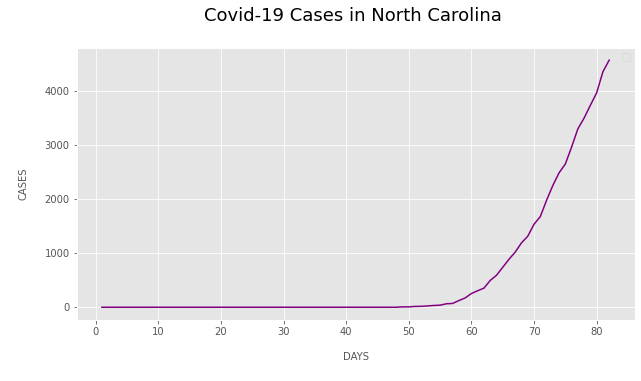

In [343]:
plt.figure(figsize = (10, 5))

plt.plot(train_df.index,train_df['ConfirmedCases'], c = 'purple')
plt.xlabel("\nDAYS\n", fontsize=10)
plt.ylabel("\nCASES\n", fontsize=10)
plt.title("Covid-19 Cases in North Carolina \n", fontsize=18)
plt.legend()
plt.show()

In [344]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

### Normalize data

In [345]:
# Get the raw data values from the pandas data frame.
data_raw = train_df.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
series = pd.DataFrame(dataset)


In [346]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.70

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (57, 25)


In [347]:

def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [348]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(55, 1)
New training data shape:
(55, 1, 1)


### Simple LSTM Network

* 1 input layer  
* 1 LSTM layer w/ 4 blocks  
* 1 Dense layer to produce a single output
* MSE loss function

In [349]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 1)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/100
55/55 [==============================] - 0s 8ms/step - loss: 7.0793e-06
Epoch 2/100
55/55 [==============================] - 0s 1ms/step - loss: 6.5065e-06
Epoch 3/100
55/55 [==============================] - 0s 1ms/step - loss: 7.1511e-06
Epoch 4/100
55/55 [==============================] - 0s 2ms/step - loss: 8.7114e-06
Epoch 5/100
55/55 [==============================] - 0s 1ms/step - loss: 7.8571e-06
Epoch 6/100
55/55 [==============================] - 0s 1ms/step - loss: 7.3361e-06
Epoch 7/100
55/55 [==============================] - 0s 1ms/step - loss: 9.6025e-06
Epoch 8/100
55/55 [==============================] - 0s 1ms/step - loss: 6.7211e-06
Epoch 9/100
55/55 [==============================] - 0s 1ms/step - loss: 6.2984e-06
Epoch 10/100
55/55 [==============================] - 0s 1ms/step - loss: 8.2178e-06
Epoch 11/100
55/55 [==============================] - 0s 1ms/step - loss: 6.3733e-06
Epoch 12/100
55/55 [==============================] - 0s 1ms/step - loss: 

55/55 [==============================] - 0s 1ms/step - loss: 5.6685e-07
Epoch 98/100
55/55 [==============================] - 0s 1ms/step - loss: 5.0543e-07
Epoch 99/100
55/55 [==============================] - 0s 1ms/step - loss: 4.6994e-07
Epoch 100/100
55/55 [==============================] - 0s 1ms/step - loss: 5.0610e-07


In [377]:
import math

def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred, orig_data)

rmse_train, train_predict,train_orig = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict, test_orig = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)


Training data score: 3.14 RMSE
Test data score: 436.55 RMSE


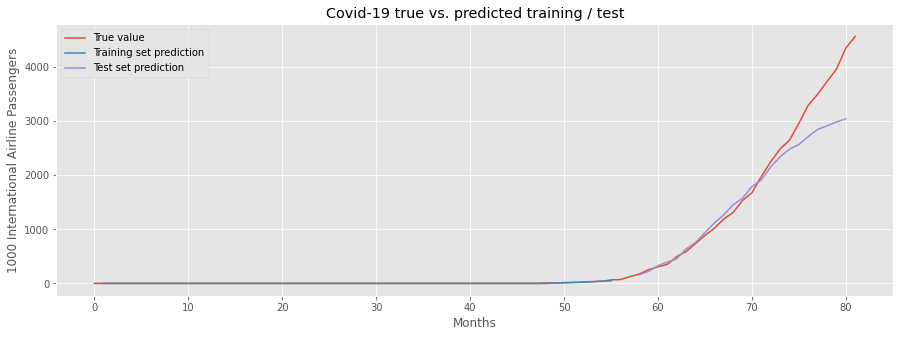

In [378]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Covid-19 true vs. predicted training / test")
plt.legend()
plt.show()

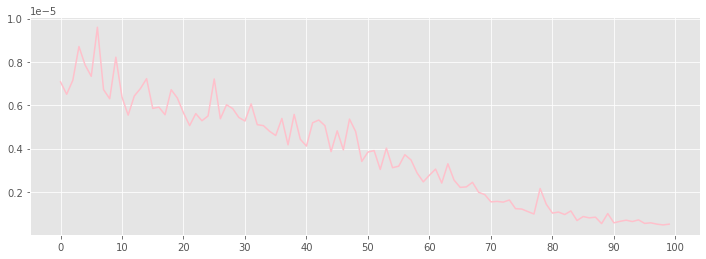

In [385]:
losses_lstm = model1.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,120,10))
plt.plot(range(len(losses_lstm)),losses_lstm, c="red");

### Bidirectional Model

In [318]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout, Bidirectional, GRU
from keras.optimizers import SGD, Adadelta, RMSprop, Adam, Nadam
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from tqdm import tqdm

reg = l1_l2(l1=0.0015, l2=0.0)
opt = Adam(lr=0.0015)


model = Sequential()
model.add(Bidirectional(LSTM(140, activation='relu', return_sequences=True, kernel_regularizer=reg, recurrent_regularizer=reg)))
model.add(Bidirectional(LSTM(140, activation='relu', return_sequences=True, kernel_regularizer=reg, recurrent_regularizer=reg)))
model.add(Bidirectional(LSTM(140, activation='relu', kernel_regularizer=reg, recurrent_regularizer=reg)))
model.add(Dense(28))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_absolute_error', optimizer=opt)

model_history = model.fit(train_X, train_Y, epochs=600, batch_size=256, validation_data=(test_X, test_Y),
                    verbose=0, shuffle=False,callbacks=[EarlyStopping(patience=10)])

In [319]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio (None, 1, 280)            159040    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 1, 280)            471520    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 280)               471520    
_________________________________________________________________
dense_27 (Dense)             (None, 28)                7868      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 29        
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 1,109,977
Trainable params: 1,109,977
Non-trainable params: 0
___________________________________________

In [320]:

predictions = model.predict(test_X)
predictions.shape

(23, 1)

In [321]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE\n\n" % rmse_test)
#model.summary()

Training data score: 12.61 RMSE
Test data score: 2230.64 RMSE




In [ ]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Covid-19 true vs. predicted training / test")
plt.legend()
plt.show()

https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras